In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")
pd.set_option("display.max_columns",300)

# Questions

1. Can I predict income inequality in a county (measured by difference between top income quintile and bottom income quintile) based on factors like:
    - Educational attainment - 
    - Proportion of population major ethnic groups - 
    - Population density - **done**
    - Birth rate - **done**
    - Unemployment rate - need to find
    - Target - diff between lowest and highest quintile **done** https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk
        - this will be positive, bounded by zero. 
        - likely NA's for some low-pop counties
2. Does median education rate impact income inequality?
3. Does birth rate impact income inequality?

# Goals for 3/13

1. Procure all listed datapoints not already in the data folder
2. Initial EDA to determine distribution of data and appropriate treatment
3. Figure out how to use:
    - education 
        - just median # of year at school? 
        - distribution across buckets (no high school diploma, some college, college degree, graduate degree)
    - major ethnic groups
        - should do proportions of each within community?
        - is there a standard measure of diversity?

In [191]:
acs_15 = pd.read_csv('data/ACS_15_5YR_S1901_with_ann_utf8.csv',header=[0,1])
geo = pd.read_csv('data/2015_demo_geo.csv')

In [192]:
def remove_columns(df, keyword):
    for column_name in df.columns:
        if keyword in column_name:
            df.drop(column_name, axis=1, inplace=True)
    return df

In [193]:
def update_column_names(df, phrase_to_remove, phrase_to_append=''):
    column_list = []
    for column_name in df.columns:
        if phrase_to_remove in column_name:
            column_name = column_name.replace(phrase_to_remove,'') + ' ' + phrase_to_append
        column_list.append(column_name.strip())
    df.columns = column_list
    return df

In [194]:
def add_pct_columns(df, column_names_to_pct, denom_column_name):
    for column_name in column_names_to_pct:
        df[column_name+'%'] = df[column_name]/df[denom_column_name]
    return df

In [195]:
def convert_to_pct_columns(df, column_names_to_pct, denom_column_name):
    for column_name in column_names_to_pct:
        df[column_name] = df[column_name]/df[denom_column_name]
    return df

In [196]:
master = pd.read_csv('data/2015_master_sd_rnd_nan_to_min.csv')
master.rename(columns={'geo_id':'County_Code'}, inplace=True)
master[master['County_Code'] == 36081]

,Unnamed: 0,County_Code,state_name,state_code,county_name,area_sqmi,log_area_sqmi,pop_est_2015,log_pop_est_2015,pop_den_2015,log_pop_den_2015,liquor_stores,household_median_income,hot_big,hot_small,bar_big,bar_small,hotels,bars,log_bars,log_hotels
1868,1868,36081,New York,NY,"Queens County, NY",108.768,2.036501,2339150,6.369058,21505.865696,4.332557,342.0,57720,111.0,252,293.0,274,363.0,567.0,2.753583,2.559907


In [210]:
''' Quintiles prep

Table is grouped by county with income means for 5 quintiles and mean for top 5%

Get data from here https://factfinder.census.gov/faces/tableservices
B19081	MEAN HOUSEHOLD INCOME OF QUINTILES
Universe: Households
Geography: All counties in US
2011-2015 American Community Survey 5-Year Estimate
'''

quintiles = pd.read_csv('data/ACS_15_5YR_B19081_with_ann.csv', header=1, encoding = "ISO-8859-1")

# drop redundant ID column
quintiles.drop('Id', axis=1, inplace=True)
# remove error columns
quintiles = remove_columns(quintiles,'Error')
# update column names to remove redundant header elements
quintiles = update_column_names(quintiles, 'Estimate; Quintile Means: - ','Mean')
# rename county columns to be consistent with other tables, rename top 5 mean to be consistent with other columns
quintiles.rename(columns={'Id2':'County_Code','Geography':'County_State','Estimate; Top 5 Percent':'Top 5% Mean' }, inplace=True)

# create income disparity column
quintiles['Diff HighestQ-LowestQ'] = quintiles['Highest Quintile Mean']\
                                    - quintiles['Lowest Quintile Mean']
quintiles['Diff Top5%-LowestQ'] = quintiles['Top 5% Mean']\
                                    - quintiles['Lowest Quintile Mean']


''' Birth Rate Prep '''

# Get data from data folder provided. Reduce to only the columns we care about
pop_estimates = pd.read_csv('data/co-est2015-alldata-utf8-3142.csv')
birth_rate = pop_estimates.loc[:,['STATE','COUNTY','STNAME','CTYNAME','POPESTIMATE2015','BIRTHS2015','RBIRTH2015']]

# Create new numeric column for county code with state + 000 county to enable merging with other dataframes
birth_rate['COUNTY']= birth_rate['COUNTY'].astype(str,'000').apply(lambda x: '{0:0>3}'.format(x))
birth_rate['County_Code'] = (birth_rate['STATE'].astype(str) + birth_rate['COUNTY']).astype(int)

    
''' Population density prep '''

master = pd.read_csv('data/2015_master_sd_rnd_nan_to_min.csv')
master.rename(columns={'geo_id':'County_Code'}, inplace=True)
pop_density = master.loc[:,['County_Code','pop_den_2015']]    
    
''' Education prep

Table is grouped by county with county population and # of adults in each bucket

Get data from here https://factfinder.census.gov/faces/tableservices
S1501	EDUCATIONAL ATTAINMENT  more information
2011-2015 American Community Survey 5-Year Estimates
ONLY include education rates for adults 25 years and up because this seems to be 
the census standard for assessing the population education rate at large '''

# import data
education_25yr = pd.read_csv('data/ACS_15_5YR_S1501_with_ann.csv', header=1, encoding = "ISO-8859-1")
# drop redundant ID column
education_25yr.drop('Id', axis=1, inplace=True)
# remove error columns
education_25yr = remove_columns(education_25yr,'Error')
# update column names to remove redundant header elements
education_25yr = update_column_names(education_25yr, 'Total; Estimate; Population 25 years and over - ')
# rename county columns to be consistent with other tables
education_25yr.rename(columns={'Id2':'County_Code','Geography':'County_State' }, inplace=True)

# change columns for rate
education_25yr = convert_to_pct_columns(education_25yr, ['Less than 9th grade',
       '9th to 12th grade, no diploma',
       'High school graduate (includes equivalency)',
       'Some college, no degree', "Associate's degree", "Bachelor's degree",
       'Graduate or professional degree'], 'Total; Estimate; Population 25 years and over')


''' Racial Groups Prep

DP05	ACS DEMOGRAPHIC AND HOUSING ESTIMATES  more information
2011-2015 American Community Survey Selected Population Tables
limitation is only includes information for people who identify as a single race.

'''

# import data
race = pd.read_csv('data/ACS_15_SPT_DP05_with_ann.csv', header=1, encoding = "ISO-8859-1")

# rename county columns to be consistent with other tables
race.rename(columns={'Id2':'County_Code','Geography':'County_State' }, inplace=True)
race['County_Code'].unique().shape
# Create pivot table to make race column headers
race_pivot = pd.pivot_table(race, index= ['County_Code','County_State'],\
                            values = 'Estimate; SEX AND AGE - Total population', \
                            columns = 'Population Group', aggfunc='sum')
race_pivot.fillna(value=0, inplace=True)
race_pivot = pd.DataFrame(race_pivot.to_records())

# Turn race variables into percentages
race_pivot['pop_total']=race_pivot.iloc[:,2:].sum(axis=1)
race_pivot.columns = ['County_Code', 'County_State',
       'American Indian/Alaska Native',
       'Asian', 'Black/African American',
       'Native Hawaiian/Pacific Islander',
       'Other', 'White', 'pop_total']

race_pivot = convert_to_pct_columns(race_pivot, ['American Indian/Alaska Native','Asian', 'Black/African American',\
                                          'Native Hawaiian/Pacific Islander','Other', 'White'],'pop_total')
                
# race_pivot.head()
# race_pivot.head()
# quintiles.tail()
# birth_rate.head()
# pop_density.head()
# education_25yr.head().round(2)

/home/alex/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5,0,'Diff Top5%-LowestQ Log')

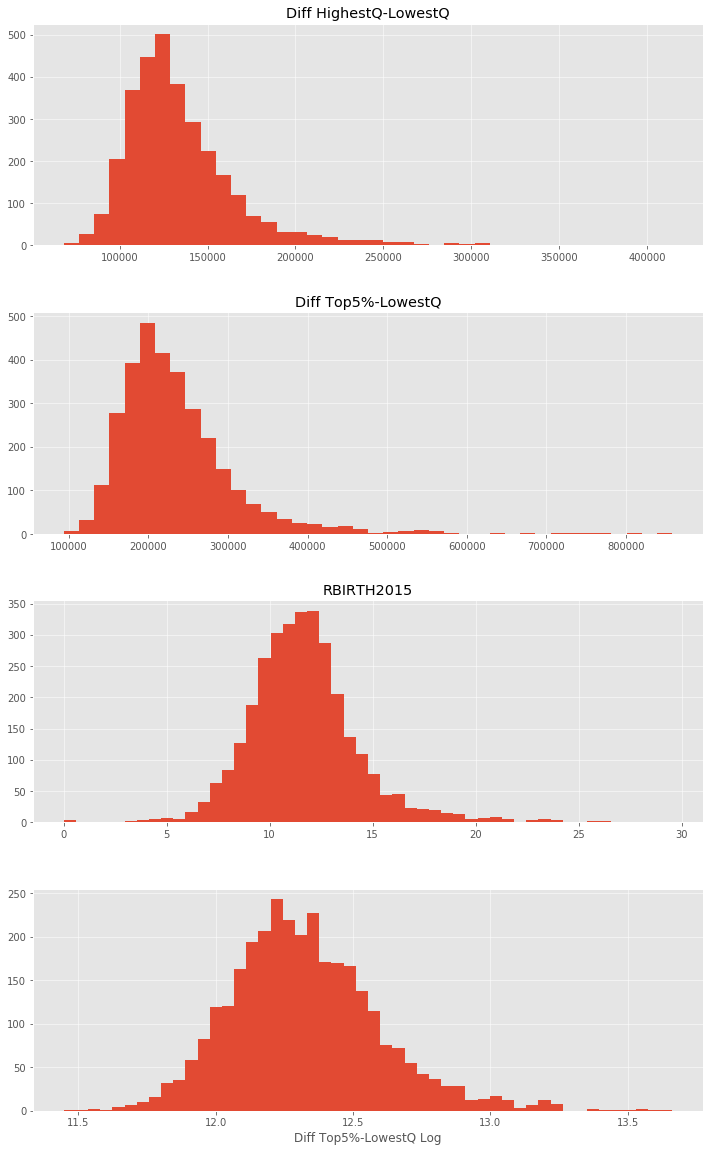

In [256]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(12,20))
# visualization
quintiles.hist(column = ['Diff HighestQ-LowestQ','Diff Top5%-LowestQ'], bins= 40, sharex=True, figsize=(10,4), ax=(ax1,ax2));
birth_rate.hist(column = 'RBIRTH2015', bins = 50, ax=ax3)

#log transform quintiles
quintiles['Diff Top5%-LowestQ'].apply(np.log).hist(bins=50, ax=ax4)
ax4.set_xlabel('Diff Top5%-LowestQ Log')


In [255]:
type(quintiles_log)

pandas.core.series.Series

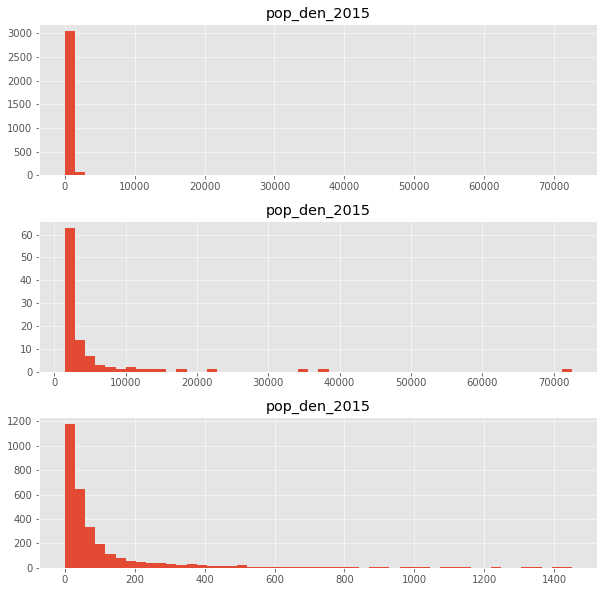

In [199]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,10))

pop_density.hist('pop_den_2015', bins=50, ax=ax1);

pop_last_100 = pop_density.sort_values('pop_den_2015')[-100:]
pop_everything_else = pop_density.sort_values('pop_den_2015')[:-100]
pop_last_100.hist('pop_den_2015', bins=50, ax=ax2);
pop_everything_else.hist('pop_den_2015', bins=50, ax=ax3);

Text(0.5,1,'Distributions of the proportions of races across US Counties')

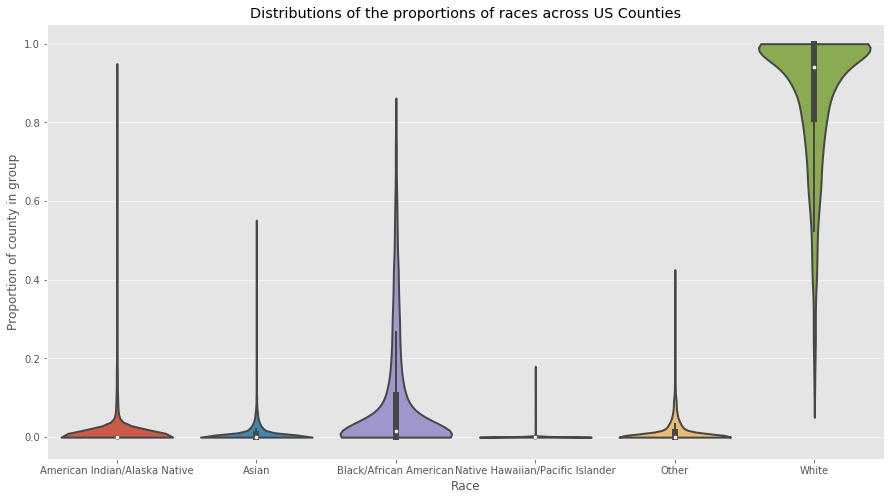

In [241]:
fig, ax = plt.subplots(1, figsize=(15,8))

race_pivot.describe().round(2)
race_pivot.columns
sns.violinplot(data=race_pivot.loc[:,['American Indian/Alaska Native', 'Asian',
       'Black/African American', 'Native Hawaiian/Pacific Islander', 'Other',
       'White']],ax=ax, scale='count', cut=0)

ax.set_ylabel('Proportion of county in group')
ax.set_xlabel('Race')
ax.set_title('Distributions of the proportions of races across US Counties')

In [243]:
race_pivot[()]

# count of counties predominantly white, pop in those counties vs pop overall


,County_Code,County_State,American Indian/Alaska Native,Asian,Black/African American,Native Hawaiian/Pacific Islander,Other,White,pop_total
0,1001,"Autauga County, Alabama",0.000000,0.000000,0.194417,0.0,0.000000,0.805583,53056.0
1,1003,"Baldwin County, Alabama",0.006082,0.006817,0.097719,0.0,0.009754,0.879629,191724.0
2,1005,"Barbour County, Alabama",0.000000,0.000000,0.479280,0.0,0.035313,0.485407,26279.0
3,1007,"Bibb County, Alabama",0.000000,0.000000,0.218554,0.0,0.000000,0.781446,22173.0
4,1009,"Blount County, Alabama",0.000000,0.000000,0.015852,0.0,0.000000,0.984148,55765.0


In [201]:
# merge the datasets on County Code


In [212]:
race.head()

,Id,County_Code,County_State,Id.1,Population Group,Estimate; SEX AND AGE - Total population,Margin of Error; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population,Percent Margin of Error; SEX AND AGE - Total population
0,0500000US01001,1001,"Autauga County, Alabama",2,White alone,42741,428,42741,(X)
1,0500000US01001,1001,"Autauga County, Alabama",4,Black or African American alone,10315,254,10315,(X)
2,0500000US01003,1003,"Baldwin County, Alabama",2,White alone,168646,727,168646,(X)
3,0500000US01003,1003,"Baldwin County, Alabama",4,Black or African American alone,18735,577,18735,(X)
4,0500000US01003,1003,"Baldwin County, Alabama",6,"American Indian and Alaska Native alone (300, ...",1166,343,1166,(X)


In [224]:
race_pivot.describe().round(2)

,County_Code,American Indian/Alaska Native,Asian,Black/African American,Native Hawaiian/Pacific Islander,Other,White,pop_total
count,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00,3140.00
mean,30382.84,0.02,0.01,0.09,0.00,0.01,0.87,97406.58
std,15161.48,0.08,0.03,0.15,0.01,0.04,0.17,312100.28
min,1001.00,0.00,0.00,0.00,0.00,0.00,0.05,259.00
25%,18178.50,0.00,0.00,0.00,0.00,0.00,0.81,10512.75
50%,29176.00,0.00,0.00,0.02,0.00,0.00,0.94,24863.50
75%,45079.50,0.00,0.01,0.11,0.00,0.01,1.00,65335.75
max,56045.00,0.95,0.55,0.86,0.18,0.43,1.00,9648558.00
